In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [12]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img/utils'))

from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Thu Sep 23 01:14:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 8000     Off  | 00000000:1B:00.0 Off |                  Off |
| 33%   56C    P2   265W / 260W |  43010MiB / 48601MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 8000     Off  | 00000000:1C:00.0 Off |                  Off |
| 43%   

## Setup imports

In [13]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    ScaleIntensityRanged,
    Spacingd,
    Lambdad,
    ToTensord,
    CastToTyped,
    DeleteItemsd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    RandSpatialCropd,
    Resized,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.15.0-154-generic)
Numpy version: 1.18.5
Pytorch version: 1.8.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.9.0+cu111
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.54.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [14]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Test

In [15]:
low_imgs      = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/20/*/*/*.npy'))
high_imgs     = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_NPY/Test/*/X/*/*/*.npy'))

dcm_low_imgs  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/20/*/*/*.dcm'))
dcm_high_imgs = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/*Brain_3mm_DCM/Test/*/X/*/*/*.dcm'))

test_files = [{"low": low_name, "high": high_name, "dcm_low" : dcm_low, "dcm_high" : dcm_high} for low_name, high_name, dcm_low, dcm_high in zip(low_imgs, high_imgs, dcm_low_imgs, dcm_high_imgs)]

print("TEST [Total]  number = ", len(low_imgs))

TEST [Total]  number =  859


## Augmentation

In [16]:
# CT에 맞는 Augmentation
from torchvision import transforms
test_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
#         CenterSpatialCropd(keys=["low", "high"], roi_size=(256, 256)),
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

In [17]:
def visual_windowing(x):
    x = (x * 0.5) + 0.5 
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

/workspace/sunggu/4.Dose_img2img/dataset/[sinogram]Brain_3mm_NPY/Test/CHO_SEU_M53/20/Head^01_ER_BrainSpiral_(Adult)_Standard_-_WFBP_20210521_163914/Brain_Axial_B40f_3.0_(3.0)_[A,0]/CHO_SEU_M53_001_20210521_164102_00021.npy
/workspace/sunggu/4.Dose_img2img/dataset/[sinogram]Brain_3mm_NPY/Test/CHO_SEU_M53/X/Head^01_ER_BrainSpiral_(Adult)_Standard_-_WFBP_20210521_163707/Brain_Axial_B40f_3.0_(3.0)_[A,0]/CHO_SEU_M53_001_20210521_163912_00021.npy
image shape: torch.Size([512, 512])


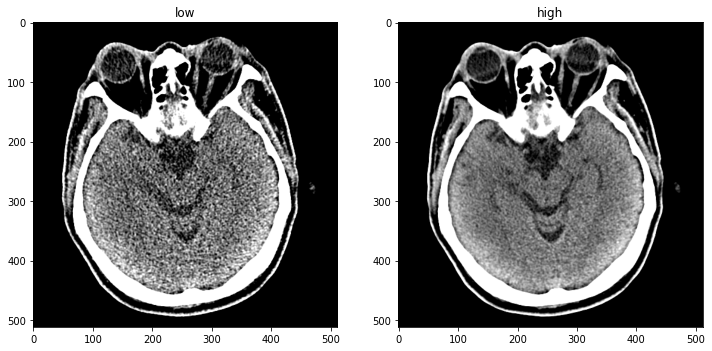

In [18]:
check_ds = Dataset(data=test_files, transform=test_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[300]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

In [19]:
import multiprocessing
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=12, drop_last=False)

CPU 갯수 =  64


## Create Model, Loss, Optimizer  Only Low -> High

In [20]:
from pix2pixHD.models import networks

device = 'cuda'

# 먼저 256x256 모델
netG = networks.define_G(input_nc=1, 
                         output_nc=1, 
                         ngf=32,                       # Local은 32로!
                         netG='local', 
                         n_downsample_global=4, 
                         n_blocks_global=9, 
                         n_local_enhancers=1, 
                         n_blocks_local=3, 
                         norm='instance')      
netD = networks.define_D(input_nc=2, 
                         ndf=64,
                         n_layers_D=3,
                         norm='instance',
                         use_sigmoid=False, 
                         num_D=3,                      # Local은 3로!
                         getIntermFeat=True)

netG.to(device)
netD.to(device)

LocalEnhancer(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (14): InstanceNorm2d(1024, eps=1e-05, momentum=0.1, affine

MultiscaleDiscriminator(
  (scale0_layer0): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (scale0_layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (scale0_layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (scale0_layer3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (scale0_layer4): Sequential(
   

## 모델 이어서 학습하기

In [21]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/Pix2Pix_2D_HD_512x512_local_2Stage/epoch_495_model.pth'
checkpoint = torch.load(checkpoint_dir)

epoch = checkpoint['epoch']
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])

## multi-gpu 사용
if torch.cuda.device_count() > 1:
    netG = torch.nn.DataParallel(netG)
    netD = torch.nn.DataParallel(netD)
    
netG.to('cuda')  
netD.to('cuda')  

print(epoch)

495


## TEST

In [22]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [23]:
def return_preprocessing(x):
    x = (4095.0)*x - 1024.0
    return x

def return_preprocessing_for_dcm(x):
    x = (4095.0)*x
    return x

In [24]:
import numpy as np
from pydicom import dcmread

def save_dicom(original_dcm_path, np_img, save_path):
    dcm = dcmread(original_dcm_path)
    
    print(np_img.max(), np_img.min(), np_img.dtype)
    
    dcm.PixelData = np_img.astype('uint16').squeeze().tobytes()
    
    dcm.save_as(save_path)
    print(save_path)

In [28]:
test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]

'/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/test_Pix2Pix_HD_2stage_epoch_495/low2high/20'

In [29]:
test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]

'/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/test_Pix2Pix_HD_2stage_epoch_495/low2high/20'

In [34]:
test_low2high_save_folder = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_'+str(epoch) + '/low2high/'
test_low2high_png_folder  = '/workspace/sunggu/4.Dose_img2img/Predictions/Test/png/Pix2Pix_HD_2stage_epoch_'+str(epoch) + '/low2high/'

with torch.no_grad():
    # Model 선언
    netG.eval()
    netD.eval()

    test_iterator = tqdm(test_loader, desc='Test', file=sys.stdout)    
    for batch_data in test_iterator:

        os.makedirs(test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8], mode=0o777, exist_ok=True)
        os.makedirs(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8], mode=0o777, exist_ok=True)
        
        # forward pass
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        # Forward Generator
        output_high = netG(input_low)

        # 저장하기
#         print(input_low.min(), input_low.max())
#         input_low[:, 128:128+256, 128:128+256, :] = 0
        input_low_dcm   = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_low)))
        input_high_dcm  = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(input_high)))
        output_high_dcm = fn_tonumpy(return_preprocessing_for_dcm(fn_denorm(output_high)))

        save_dicom(batch_data['dcm_low'][0],  input_low_dcm,   test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1])        
        save_dicom(batch_data['dcm_high'][0], input_high_dcm,  test_low2high_save_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1])
        save_dicom(batch_data['dcm_low'][0],  output_high_dcm, test_low2high_save_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1])        

        
        # png Save
        input_low   = fn_denorm_window(fn_tonumpy((input_low)))
        input_high  = fn_denorm_window(fn_tonumpy((input_high)))
        output_high = fn_denorm_window(fn_tonumpy((output_high)))

        input_low   = np.clip(input_low, a_min=0, a_max=1)
        input_high  = np.clip(input_high, a_min=0, a_max=1)
        output_high = np.clip(output_high, a_min=0, a_max=1)
        
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/gt_low_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
#                    input_low[0].squeeze(),   cmap="gray")
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_high'][0].split('/')[8]+'/gt_high_' +batch_data['dcm_high'][0].split('/')[-1].replace('.dcm', '.png'),
#                    input_high[0].squeeze(),   cmap="gray")
#         plt.imsave(test_low2high_png_folder+batch_data['dcm_low'][0].split('/')[8]+'/pred_high_' +batch_data['dcm_low'][0].split('/')[-1].replace('.dcm', '.png'),
#                    output_high[0].squeeze(),   cmap="gray")        
                
#         plt.figure(figsize=(12,12))
#         plt.subplot(131)
#         plt.imshow(input_low.squeeze(), 'gray')
#         plt.subplot(132)
#         plt.imshow(input_high.squeeze(), 'gray')
#         plt.subplot(133)
#         plt.imshow(output_high.squeeze(), 'gray')
#         plt.show()
                                     
          

Test:   0%|          | 0/859 [00:00<?, ?it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00001.dcm
3908.756 1.0111057 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00001.dcm
Test:   0%|          | 1/859 [00:00<07:38,  1.87it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00002.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00002.dcm
3899.0718 1.150842 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/

Test:   2%|▏         | 16/859 [00:02<01:24,  9.95it/s]2694.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00017.dcm
2677.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00017.dcm
2679.9382 0.23822308 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154508_00017.dcm
2681.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154508_00018.dcm
2675.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00018.dcm
2669.0068 0.07420063 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/

Test:   4%|▎         | 32/859 [00:03<01:32,  8.95it/s]2668.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00033.dcm
2662.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00033.dcm
2636.6506 0.31498656 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00033.dcm
2676.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00034.dcm
2668.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00034.dcm
2660.3918 0.30119598 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/

Test:   6%|▌         | 48/859 [00:05<01:38,  8.23it/s]2602.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00049.dcm
2584.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00049.dcm
2505.07 0.8712472 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_HYE_F39_001_20210521_154509_00049.dcm
2568.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_HYE_F39_001_20210521_154509_00050.dcm
2551.0 2.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_HYE_F39_001_20210521_154318_00050.dcm
2446.277 1.1008054 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00001.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00001.dcm
3933.2742 1.3699048 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00001.dcm
3805.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00002.dcm
3805.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00002.dcm
3578.9324 0.95997065 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210

Test:   8%|▊         | 72/859 [00:07<01:03, 12.33it/s]2780.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00017.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00017.dcm
2798.678 0.4242128 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00017.dcm
2718.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00018.dcm
2709.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00018.dcm
2725.4634 0.32218695 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoc

Test:  10%|█         | 88/859 [00:08<01:02, 12.39it/s]2531.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00033.dcm
2535.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00033.dcm
2547.2954 0.3651452 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00033.dcm
2524.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00034.dcm
2529.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00034.dcm
2533.455 0.33134 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_4

Test:  12%|█▏        | 104/859 [00:09<01:04, 11.75it/s]2355.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00049.dcm
2351.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00049.dcm
2444.368 1.1227727 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_160415_00049.dcm
2424.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_160415_00050.dcm
2410.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_160226_00050.dcm
2440.422 4.816207 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_

2661.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00007.dcm
2710.4426 0.25250182 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00007.dcm
Test:  14%|█▍        | 120/859 [00:11<01:13, 10.03it/s]2607.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00008.dcm
2601.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00008.dcm
2631.6133 0.35050035 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00008.dcm
2642.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stag

2622.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00023.dcm
2654.8657 0.38845494 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00023.dcm
Test:  16%|█▌        | 136/859 [00:12<01:04, 11.21it/s]2591.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00024.dcm
2592.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00024.dcm
2593.0283 0.41689038 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00024.dcm
2584.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stag

2520.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00039.dcm
2513.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00039.dcm
2517.7825 0.42079568 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00039.dcm
Test:  18%|█▊        | 152/859 [00:13<00:54, 12.99it/s]2452.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00040.dcm
2453.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00040.dcm
2453.8643 1.1432755 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_ep

1514.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00055.dcm
1520.0 7.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00055.dcm
1516.6812 4.980351 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_KYE_HWA_M80_001_20210521_161342_00055.dcm
Test:  20%|█▉        | 168/859 [00:15<00:59, 11.65it/s]988.99994 0.99999994 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_KYE_HWA_M80_001_20210521_161342_00056.dcm
985.99994 7.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_KYE_HWA_M80_001_20210521_161153_00056.dcm
1016.52924 3.7700753 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/

2823.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00014.dcm
2834.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00014.dcm
2813.788 0.2804491 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00014.dcm
Test:  21%|██▏       | 184/859 [00:16<00:58, 11.56it/s]3715.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00015.dcm
3722.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00015.dcm
3480.051 0.27642176 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pr

2614.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00030.dcm
2607.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00030.dcm
2616.6917 0.38064435 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00030.dcm
Test:  23%|██▎       | 200/859 [00:17<00:52, 12.62it/s]2598.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00031.dcm
2585.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00031.dcm
2593.289 0.3702709 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/p

2538.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00046.dcm
2535.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00046.dcm
2565.3438 1.7136929 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_MYE_F71_001_20210521_162245_00046.dcm
Test:  25%|██▌       | 216/859 [00:19<00:54, 11.80it/s]2490.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_MYE_F71_001_20210521_162245_00047.dcm
2501.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_MYE_F71_001_20210521_162055_00047.dcm
2524.3982 1.3761288 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/p

2786.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00005.dcm
2776.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00005.dcm
2741.2954 2.199536 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00005.dcm
Test:  27%|██▋       | 232/859 [00:20<00:59, 10.52it/s]2669.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00006.dcm
2664.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00006.dcm
2626.7395 0.8591652 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoc

2675.33 0.30864045 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00020.dcm
2669.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00021.dcm
2673.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00021.dcm
2665.556 0.35013422 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00021.dcm
Test:  29%|██▉       | 248/859 [00:22<00:54, 11.27it/s]2719.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00022.dcm
2719.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_e

Test:  31%|███       | 262/859 [00:23<01:04,  9.30it/s]2559.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00036.dcm
2554.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00036.dcm
2534.2515 0.25811568 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00036.dcm
2555.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00037.dcm
2547.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00037.dcm
2541.0967 0.23627043 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_e

Test:  32%|███▏      | 278/859 [00:24<00:46, 12.41it/s]1028.0 1.9999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00052.dcm
1016.99994 13.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00052.dcm
1999.2008 0.060288012 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_SEO_LYE_F65_001_20210521_163157_00052.dcm
1037.0 2.9999998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEO_LYE_F65_001_20210521_163157_00053.dcm
1019.99994 13.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEO_LYE_F65_001_20210521_163014_00053.dcm
1978.2927 0.0617525 float32
/workspace/sunggu/4.Dose_img2img/Predicti

Test:  34%|███▍      | 294/859 [00:26<00:52, 10.82it/s]2730.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00015.dcm
2723.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00015.dcm
2681.2397 0.026848912 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00015.dcm
2742.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00016.dcm
2741.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163912_00016.dcm
2711.9216 0.051623136 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/

Test:  36%|███▌      | 310/859 [00:27<00:46, 11.75it/s]2769.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00031.dcm
2774.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00031.dcm
2724.927 0.11044666 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00031.dcm
2795.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00032.dcm
2785.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00032.dcm
2739.8433 0.10788381 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/

Test:  38%|███▊      | 326/859 [00:29<00:46, 11.45it/s]2565.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00047.dcm
2566.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00047.dcm
2523.2017 0.03600195 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_SEU_M53_001_20210521_164102_00047.dcm
2567.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_SEU_M53_001_20210521_164102_00048.dcm
2559.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_SEU_M53_001_20210521_163913_00048.dcm
2439.401 0.10593116 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/

2796.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00006.dcm
2809.5662 0.14205515 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00006.dcm
Test:  40%|███▉      | 342/859 [00:30<00:48, 10.65it/s]2831.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00007.dcm
2819.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00007.dcm
2840.2844 0.56175244 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00007.dcm
2733.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stag

2621.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00022.dcm
2610.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00022.dcm
2604.3152 0.41798875 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00022.dcm
Test:  42%|████▏     | 358/859 [00:31<00:39, 12.56it/s]2621.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00023.dcm
2621.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00023.dcm
2610.263 0.48523307 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_ep

2641.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00038.dcm
2639.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00038.dcm
2619.46 0.3329265 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165015_00038.dcm
Test:  44%|████▎     | 374/859 [00:33<00:36, 13.12it/s]2614.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165015_00039.dcm
2618.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00039.dcm
2600.566 0.2443251 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00053.dcm
1309.8823 4.202099 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165016_00053.dcm
1041.0 8.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHO_YON_SOO_F65_001_20210521_165016_00054.dcm
1037.0 12.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHO_YON_SOO_F65_001_20210521_164829_00054.dcm
1151.7831 2.885892 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHO_YON_SOO_F65_001_20210521_165016_00054.dcm
Test:  45%|████▌     | 390/859 [00:34<00:37, 12.43it/s]1039.0 4.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoc

Test:  47%|████▋     | 404/859 [00:35<00:36, 12.47it/s]2941.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00014.dcm
2923.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00014.dcm
2842.1897 0.0020746887 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00014.dcm
2878.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00015.dcm
2869.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00015.dcm
2825.3064 0.0025628507 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2hig

2617.4873 0.038930923 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00029.dcm
Test:  49%|████▉     | 420/859 [00:37<00:38, 11.35it/s]2606.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00030.dcm
2606.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00030.dcm
2603.8418 0.031730533 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00030.dcm
2613.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00031.dcm
2605.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2hi

Test:  51%|█████     | 436/859 [00:38<00:33, 12.59it/s]2600.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00046.dcm
2597.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00046.dcm
2587.953 0.06956309 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_BYE_M49_001_20210521_170938_00046.dcm
2592.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_BYE_M49_001_20210521_170938_00047.dcm
2595.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_BYE_M49_001_20210521_170743_00047.dcm
2578.9946 0.05516231 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/

Test:  53%|█████▎    | 452/859 [00:39<00:31, 12.93it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00002.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171740_00002.dcm
3867.2622 0.41566998 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171940_00002.dcm
2840.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00003.dcm
2837.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171740_00003.dcm
2807.9375 1.1114229 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_ep

Test:  54%|█████▍    | 468/859 [00:41<00:33, 11.74it/s]2906.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00018.dcm
2908.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00018.dcm
2872.892 0.60202587 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171940_00018.dcm
2863.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171940_00019.dcm
2859.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00019.dcm
2826.36 0.80034167 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoc

Test:  56%|█████▋    | 484/859 [00:42<00:30, 12.25it/s]2638.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00034.dcm
2637.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00034.dcm
2617.297 0.2750793 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_00034.dcm
2632.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00035.dcm
2626.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00035.dcm
2611.938 0.26861116 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoc

Test:  58%|█████▊    | 500/859 [00:43<00:30, 11.77it/s]2440.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00050.dcm
2440.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00050.dcm
2424.9739 0.6789113 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUL_YEO_M60_001_20210521_171941_00050.dcm
2465.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUL_YEO_M60_001_20210521_171941_00051.dcm
2461.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUL_YEO_M60_001_20210521_171741_00051.dcm
2448.054 2.6659749 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoc

2704.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00002.dcm
2716.4377 1.7936294 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00002.dcm
Test:  60%|██████    | 516/859 [00:45<00:34,  9.82it/s]2677.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00003.dcm
2665.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00003.dcm
2677.8213 1.8544055 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00003.dcm
2678.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_

2661.452 0.23712471 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00017.dcm
2611.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00018.dcm
2608.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00018.dcm
2614.096 0.09506956 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00018.dcm
Test:  62%|██████▏   | 532/859 [00:46<00:28, 11.54it/s]2662.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00019.dcm
2646.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_

Test:  64%|██████▎   | 547/859 [00:48<00:35,  8.85it/s]2657.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00034.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00034.dcm
2633.7043 0.24054185 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00034.dcm
2649.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00035.dcm
2641.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00035.dcm
2629.1562 0.2747132 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_ep

Test:  66%|██████▌   | 563/859 [00:49<00:21, 13.69it/s]2501.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00050.dcm
2498.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00050.dcm
2434.5073 0.44691235 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_EUN_SEO_F18_001_20210521_172947_00050.dcm
2527.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_EUN_SEO_F18_001_20210521_172947_00051.dcm
2528.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_EUN_SEO_F18_001_20210521_172753_00051.dcm
2424.15 0.5235538 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoc

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00006.dcm
2745.2893 0.33658773 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_00006.dcm
Test:  67%|██████▋   | 579/859 [00:50<00:24, 11.31it/s]2779.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00007.dcm
2781.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00007.dcm
2752.0544 0.27690992 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_00007.dcm
2952.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2hig

2658.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00022.dcm
2656.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00022.dcm
2619.4294 0.47546983 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173914_00022.dcm
Test:  69%|██████▉   | 595/859 [00:52<00:20, 13.04it/s]2668.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173914_00023.dcm
2650.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00023.dcm
2642.9985 0.47815472 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_e

2476.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173915_00038.dcm
2465.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00038.dcm
2445.4001 0.5607761 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HEE_JEO_F52_001_20210521_173915_00038.dcm
Test:  71%|███████   | 611/859 [00:53<00:19, 12.64it/s]2439.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HEE_JEO_F52_001_20210521_173915_00039.dcm
2432.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HEE_JEO_F52_001_20210521_173730_00039.dcm
2412.7712 0.3949231 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epo

2861.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174835_00001.dcm
2862.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00001.dcm
2828.0828 0.41200876 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174835_00001.dcm
Test:  73%|███████▎  | 627/859 [00:54<00:18, 12.74it/s]2813.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174835_00002.dcm
2818.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00002.dcm
2768.6199 0.6304613 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_ep

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00016.dcm
2883.9954 0.0578472 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00016.dcm
2867.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00017.dcm
2859.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00017.dcm
2863.4775 0.17598242 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00017.dcm
Test:  75%|███████▍  | 643/859 [00:56<00:19, 11.21it/s]2762.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00031.dcm
Test:  76%|███████▋  | 657/859 [00:57<00:16, 11.99it/s]2627.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00032.dcm
2627.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00032.dcm
2612.8062 0.25884792 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00032.dcm
2615.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00033.dcm
2594.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_hig

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00047.dcm
2379.2969 0.46839148 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00047.dcm
Test:  78%|███████▊  | 673/859 [00:58<00:17, 10.59it/s]2401.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HUN_SUK_M42_001_20210521_174836_00048.dcm
2401.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HUN_SUK_M42_001_20210521_174641_00048.dcm
2388.843 0.35892114 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HUN_SUK_M42_001_20210521_174836_00048.dcm
2387.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00003.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00004.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00004.dcm
3809.5613 0.2843544 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00004.dcm
Test:  80%|████████  | 689/859 [01:00<00:14, 11.52it/s]3442.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00005.dcm
3430.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HWA_M37_001_202

2710.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00020.dcm
2700.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00020.dcm
2722.6082 0.032340735 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00020.dcm
Test:  82%|████████▏ | 705/859 [01:01<00:12, 12.51it/s]2731.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00021.dcm
2724.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00021.dcm
2718.4714 0.08432999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/2

3945.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00036.dcm
3942.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00036.dcm
3684.729 0.10312423 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00036.dcm
Test:  84%|████████▍ | 721/859 [01:03<00:18,  7.32it/s]4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00037.dcm
4095.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00037.dcm
3832.5808 0.058457404 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20

Test:  86%|████████▌ | 736/859 [01:04<00:11, 11.14it/s]2511.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00052.dcm
2508.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00052.dcm
2303.3257 1.4116426 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_HWA_M37_001_20210521_175829_00052.dcm
2511.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_HWA_M37_001_20210521_175829_00053.dcm
2501.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_HWA_M37_001_20210521_175634_00053.dcm
2193.3345 9.4753475 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/p

Test:  88%|████████▊ | 752/859 [01:06<00:10, 10.10it/s]2828.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180811_00008.dcm
2833.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00008.dcm
2803.6943 0.14840126 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180811_00008.dcm
2956.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180811_00009.dcm
2947.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00009.dcm
2927.8245 0.16365632 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_e

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00023.dcm
Test:  89%|████████▉ | 768/859 [01:07<00:08, 11.09it/s]2716.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00024.dcm
2713.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00024.dcm
2707.7349 0.30119598 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00024.dcm
2724.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00025.dcm
2719.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_hig

2583.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00039.dcm
2578.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00039.dcm
2571.375 0.10727361 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00039.dcm
Test:  91%|█████████▏| 784/859 [01:08<00:06, 11.89it/s]2603.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00040.dcm
2600.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00040.dcm
2585.8423 0.10690749 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_ep

382.99997 10.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_LYE_HOO_F50_001_20210521_180812_00055.dcm
380.99997 15.999999 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_LYE_HOO_F50_001_20210521_180624_00055.dcm
396.90515 1.6095923 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_LYE_HOO_F50_001_20210521_180812_00055.dcm
Test:  93%|█████████▎| 800/859 [01:10<00:04, 13.21it/s]2966.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00001.dcm
2973.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00001.dcm
2937.6785 1.7592139 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix

2863.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00016.dcm
2855.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00016.dcm
2844.2795 0.18000975 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00016.dcm
Test:  95%|█████████▍| 816/859 [01:11<00:03, 11.07it/s]2907.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00017.dcm
2925.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00017.dcm
2885.8076 0.3389065 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_ep

2588.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00032.dcm
2585.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00032.dcm
2570.5715 0.5989748 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00032.dcm
Test:  97%|█████████▋| 832/859 [01:13<00:02, 11.95it/s]2597.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00033.dcm
2591.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00033.dcm
2578.5623 0.59567976 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_ep

/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00047.dcm
2369.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00048.dcm
2348.0 4.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X/gt_high_CHU_SOO_SEO_F65_001_20210521_165744_00048.dcm
2357.2 1.102758 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/pred_high_CHU_SOO_SEO_F65_001_20210521_165937_00048.dcm
Test:  99%|█████████▊| 848/859 [01:14<00:00, 11.73it/s]2384.0 0.0 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/20/gt_low_CHU_SOO_SEO_F65_001_20210521_165937_00049.dcm
2396.0 6.9999995 float32
/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/Pix2Pix_HD_2stage_epoch_495/low2high/X

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)

## GAN image Metric

### Pred dcm 경로

In [ ]:
# real_dcm_low_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*50/b40f/*/Brain*B40f_3.0*/*.dcm"))
# real_dcm_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/goto_sinogram/brain/*/n*100/b40f/*/Brain*B40f_3.0*/*.dcm"))

In [14]:
model_dir = "test_Pix2Pix_HD_2stage_epoch_495"
dcm_low_images   = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_low*.dcm"))
dcm_high_images  = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/gt_high*.dcm"))
pred_high_images = list_sort_nicely(glob.glob("/workspace/sunggu/4.Dose_img2img/Predictions/Test/dcm/"+model_dir+"/low2high/*/pred*.dcm"))


In [15]:
def CT_12bit_processing(x):
    # H, W, D
    x[x < -1024.0] = -1024.0
    x[x > 3072.0] = 3072.0
    x = (x + 1024.0) / 4095.0
    
    return x

In [16]:
from pydicom import dcmread
import SimpleITK as sitk

gt_tp_list   =[]
pred_tp_list =[]
input_tp_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    np_gt_H    = CT_12bit_processing(np_gt_H)
    np_pred_H  = CT_12bit_processing(np_pred_H)
    np_input_L = CT_12bit_processing(np_input_L)
    
    tp_gt_H   = torch.from_numpy(np_gt_H)
    tp_pred_H = torch.from_numpy(np_pred_H)  # 1, 512, 512
    tp_pred_L = torch.from_numpy(np_input_L)  # 1, 512, 512
    
    gt_tp_list.append(tp_gt_H)
    pred_tp_list.append(tp_pred_H)
    input_tp_list.append(tp_pred_L)
    
gt_zip    = torch.stack(gt_tp_list, dim=0)
pred_zip  = torch.stack(pred_tp_list, dim=0)
input_zip = torch.stack(input_tp_list, dim=0)


449it [00:18, 24.29it/s]


### SSIM

In [ ]:
# x: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).
# y: Tensor with shape 2D (H, W), 3D (C, H, W), 4D (N, C, H, W) or 5D (N, C, H, W, 2).


In [52]:
import piq

prediction  = pred_zip
target      = gt_zip
input       = input_zip

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(prediction, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss = piq.SSIMLoss(data_range=1.0)(prediction, target)
print(f"model SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")

# To compute SSIM index as a measure, use lower case function from the library:
ssim_index = piq.ssim(input, target, data_range=1.0)
# In order to use SSIM as a loss function, use corresponding PyTorch module:
ssim_loss: torch.Tensor = piq.SSIMLoss(data_range=1.0)(input, target)
print(f"Input SSIM index: {ssim_index.item():0.4f}, loss: {ssim_loss.item():0.4f}")


model SSIM index: 0.9924, loss: 0.0076
Input SSIM index: 0.9974, loss: 0.0026


### PSNR

In [53]:
import piq

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(prediction, target, data_range=1.0, reduction='none')
print(f"model PSNR index: {psnr_index.mean():0.4f}")

# To compute PSNR as a measure, use lower case function from the library.
psnr_index = piq.psnr(input, target, data_range=1.0, reduction='none')
print(f"Input PSNR index: {psnr_index.mean():0.4f}")

model PSNR index: 50.2951
Input PSNR index: 56.4575


### 다시 PSNR 수정!

In [ ]:
def cal_PSNR(x):
    peak_pixel = x.max()
    patch_air  = x.squeeze()[30:60, 250:280]
    score = 10*np.log10( peak_pixel ** 2 / np.var(patch_air.flatten()))
    
    return score

In [ ]:
from pydicom import dcmread
import SimpleITK as sitk

gt_H_list   =[]
pred_H_list =[]
input_L_list =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))
    
    gt_H_list    = cal_PSNR(np_gt_H)
    pred_H_list  = cal_PSNR(np_pred_H)
    input_L_list = cal_PSNR(np_input_L)


In [ ]:
print(np.mean(gt_H_list))
print(np.mean(pred_H_list))
print(np.mean(input_L_list))

## MSE

In [19]:
import math

def MSE(inputs, target):
    mse  = np.mean( (inputs - target) ** 2 )
    return mse

In [51]:
from pydicom import dcmread
import SimpleITK as sitk

pred_high_mse_list   =[]
input_high_mse_list    =[]

for dcm_high_path, pred_high_path, input_path in tqdm(zip(dcm_high_images, pred_high_images, dcm_low_images)):
    
    np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_path))
    np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_path))
    np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(input_path))

    pred_high_mse    = MSE(np_gt_H, np_pred_H)
    input_high_mse   = MSE(np_gt_H, np_input_L)
    
    pred_high_mse_list.append(pred_high_mse)
    input_high_mse_list.append(input_high_mse)
    
print(f"Model MSE = {np.mean(pred_high_mse_list):0.4f}")
print()
print(f"Input MSE = {np.mean(input_high_mse_list):0.4f}")

449it [00:07, 60.81it/s]

Model MSE = 228.4929

Input MSE = 41.5295


## Difference Map

In [61]:
i = 42
np_gt_H    = sitk.GetArrayFromImage(sitk.ReadImage(dcm_high_images[i]))
np_pred_H  = sitk.GetArrayFromImage(sitk.ReadImage(pred_high_images[i]))
np_input_L = sitk.GetArrayFromImage(sitk.ReadImage(dcm_low_images[i]))

In [62]:
def pure_window(x):
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    return x

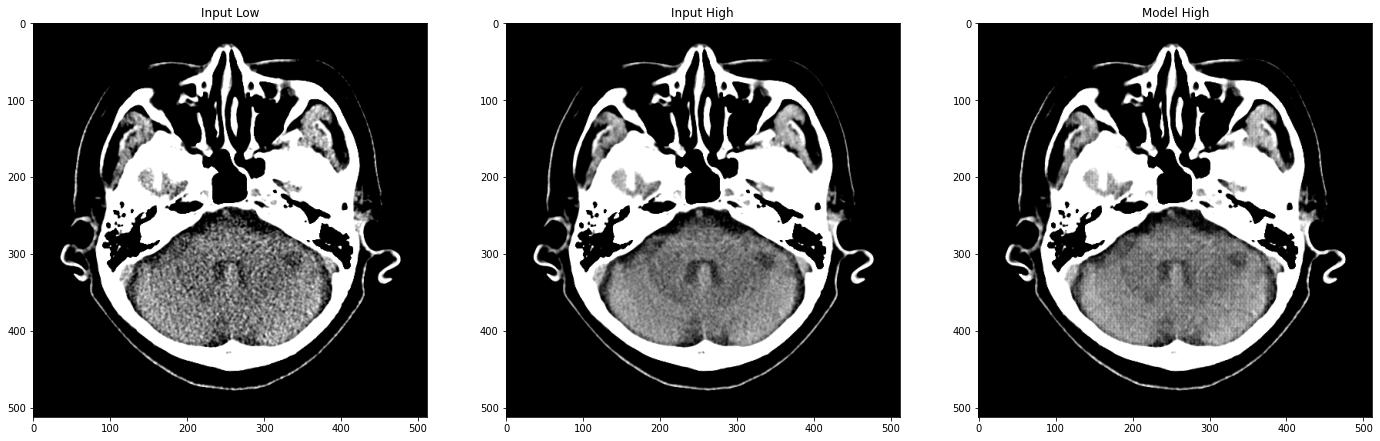

In [63]:
plt.figure(figsize=(24, 12))
plt.subplot(131)
plt.imshow(pure_window(CT_12bit_processing(np_input_L[0])), 'gray')
plt.title("Input Low")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_low.png', pure_window(CT_12bit_processing(np_input_L[0])),   cmap="gray")

plt.subplot(132)
plt.imshow(pure_window(CT_12bit_processing(np_gt_H[0])), 'gray')
plt.title("Input High")
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_high.png', pure_window(CT_12bit_processing(np_gt_H[0])),   cmap="gray")

plt.subplot(133)
plt.imshow(pure_window(CT_12bit_processing(np_pred_H[0])), 'gray')
plt.title("Model High")
plt.imsave('/workspace/sunggu/4.Dose_img2img/model_high_pix.png', pure_window(CT_12bit_processing(np_pred_H[0])),   cmap="gray")

plt.show()

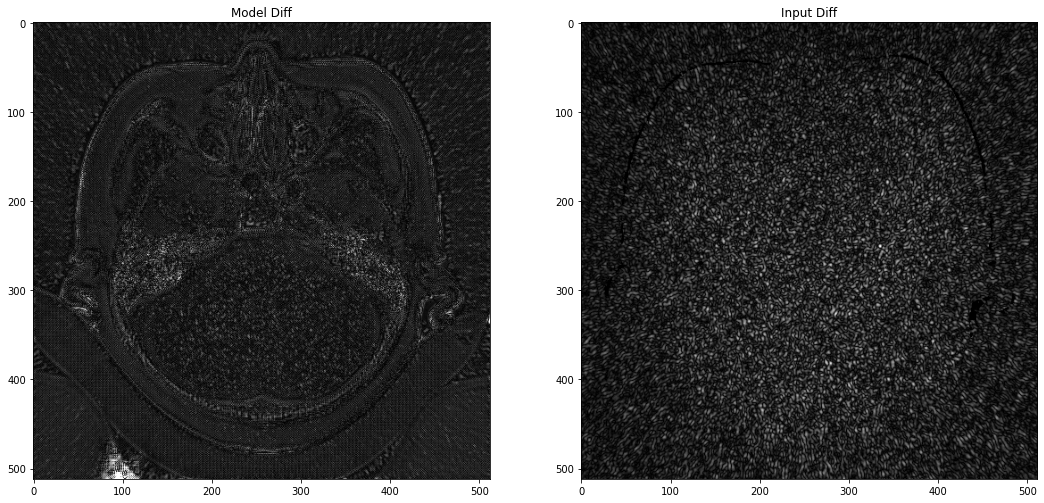

In [77]:
plt.figure(figsize=(18, 12))
plt.subplot(121)

# plt.imsave('/workspace/sunggu/4.Dose_img2img/model_diff_pix.png', np.abs(np_pred_H - np_input_L)[0],   cmap="gray")
t = np.abs(np_pred_H - np_input_L)[0]
t = np.clip(t, a_min=0.0, a_max=60.0)
plt.imshow(t, 'gray')
plt.title("Model Diff")


plt.subplot(122)
t = np.abs(np_gt_H - np_input_L)[0]
t = np.clip(t, a_min=0.0, a_max=60.0)
plt.imshow(t, 'gray')
plt.title("Input Diff")

# plt.imshow(np.abs(np_gt_H - np_input_L)[0], 'gray')
# plt.imsave('/workspace/sunggu/4.Dose_img2img/input_diff.png', np.abs(np_gt_H - np_input_L)[0],   cmap="gray")

plt.show()

In [65]:
np.abs(np_pred_H - np_input_L)[0].max(), np.abs(np_gt_H - np_pred_H)[0].min(), np.abs(np_gt_H - np_pred_H)[0].mean()

(502, 0, 7.7294769287109375)

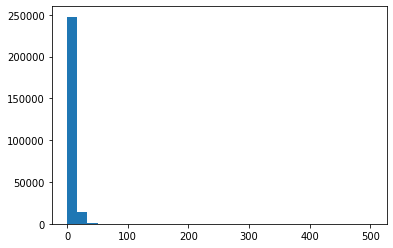

In [66]:
n, bins, patches = plt.hist(np.abs(np_pred_H - np_input_L)[0].flatten(), bins=30)

In [73]:
np.abs(np_gt_H - np_input_L)[0].max(), np.abs(np_gt_H - np_input_L)[0].min(), np.abs(np_gt_H - np_input_L)[0].mean()

(40, 0, 5.165294647216797)

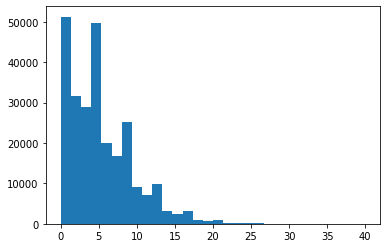

In [74]:
n, bins, patches = plt.hist(np.abs(np_gt_H - np_input_L)[0].flatten(), bins=30)